In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image
import os
from sklearn.model_selection import train_test_split

In [55]:
pokemon_df = pd.read_csv('pokemon.csv')
pokemon_df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


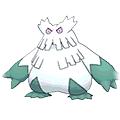

In [48]:
Image(filename=pokemon_imgs[0])

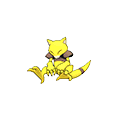

In [49]:
Image(filename=pokemon_imgs[1])

In [61]:
pokemon_imgs = os.listdir('images')

sorted_imgs = pokemon_imgs.copy()
for pokemon in pokemon_imgs:
    pokemon_name = pokemon.split('.')[0]
    index = pokemon_df[pokemon_df.Name == pokemon_name].index.values[0]
    sorted_imgs[index] = pokemon

In [63]:
pokemon_df['Pokemon Image'] = sorted_imgs

In [67]:
if not os.path.exists('train/'):
    os.mkdir('train/')
if not os.path.exists('test/'):
    os.mkdir('test/')

In [68]:
for pk_type in pokemon_df.Type1.unique():
    if not os.path.exists('train/'+str(pk_type)+'/'):
        os.mkdir('train/'+str(pk_type)+'/')
    if not os.path.exists('val/'+str(pk_type)+'/'):
        os.mkdir('val/'+str(pk_type)+'/')

In [76]:
X_train, X_test, y_train, y_test = train_test_split(pokemon_df['Pokemon Image'], pokemon_df.Type1, 
                                                    test_size=0.3, stratify=pokemon_df.Type1, random_state=42)

In [78]:
for pk, pk_type in zip(f'images/{X_train}', y_train):
        

dialga.png
camerupt.png
regice.png
mudsdale.jpg
zebstrika.png
magneton.png
nosepass.png
pyukumuku.jpg
skuntank.png
togedemaru.jpg
gothitelle.png
munna.png
tirtouga.png
omastar.png
drampa.jpg
chesnaught.png
dewott.png
mantyke.png
stunfisk.png
infernape.png
floatzel.png
cyndaquil.png
accelgor.png
patrat.png
exeggutor.png
cutiefly.jpg
plusle.png
swellow.png
chimchar.png
dewpider.jpg
genesect.png
pansear.png
conkeldurr.png
espurr.png
munchlax.png
groudon.png
spheal.png
magmar.png
ekans.png
salazzle.jpg
zekrom.png
zygarde-50.png
kingdra.png
simisear.png
pelipper.png
horsea.png
sableye.png
unfezant.png
shroomish.png
lycanroc-midday.jpg
clauncher.png
hoopa-confined.png
charizard.png
honedge.png
porygon2.png
metang.png
carracosta.png
leavanny.png
darkrai.png
yanma.png
liepard.png
murkrow.png
mareanie.jpg
burmy.png
shiftry.png
ledyba.png
noibat.png
armaldo.png
hypno.png
noivern.png
shedinja.png
arbok.png
fraxure.png
chingling.png
nidoran-m.png
archen.png
turtwig.png
gigalith.png
vivillon.png
vi